In [3]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim

In [4]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [5]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 8, 10,  2,  0,  5,  4,  7,  1,  9]), tensor([3, 6]))

In [30]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [38]:
linear_model = nn.Linear(1,1)
t_un_val, linear_model(t_un_val)

(tensor([[8.1900],
         [3.3900]]),
 tensor([[-4.3550],
         [-1.7859]], grad_fn=<AddmmBackward0>))

In [34]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[0.9585]], requires_grad=True),
 Parameter containing:
 tensor([-0.7226], requires_grad=True))

In [39]:
x = torch.ones(1)
linear_model(x)

tensor([-0.5067], grad_fn=<ViewBackward0>)

In [40]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.5067],
        [-0.5067],
        [-0.5067],
        [-0.5067],
        [-0.5067],
        [-0.5067],
        [-0.5067],
        [-0.5067],
        [-0.5067],
        [-0.5067]], grad_fn=<AddmmBackward0>)

In [45]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.9794]], requires_grad=True),
 Parameter containing:
 tensor([0.1933], requires_grad=True)]

In [46]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)
optimizer, list(linear_model.parameters())

(SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ),
 [Parameter containing:
  tensor([[-0.2029]], requires_grad=True),
  Parameter containing:
  tensor([-0.1861], requires_grad=True)])

In [47]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, 1+n_epochs):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch: {epoch}, training loss:{loss_train.item():.4f}, "
                  f"validation loss: {loss_val.item():.4f}")


In [49]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
training_loop(n_epochs=3000, optimizer=optimizer, model=linear_model,
              loss_fn=loss_fn, t_u_train=t_un_train, t_u_val=t_un_val,
              t_c_train=t_c_train, t_c_val=t_c_val)

print("====")
print(linear_model.weight)
print(linear_model.bias)

Epoch: 1, training loss:65.5036, validation loss: 221.5381
Epoch: 1000, training loss:4.2631, validation loss: 9.8920
Epoch: 2000, training loss:2.8572, validation loss: 5.1746
Epoch: 3000, training loss:2.7431, validation loss: 4.7335
====
Parameter containing:
tensor([[5.2483]], requires_grad=True)
Parameter containing:
tensor([-17.0613], requires_grad=True)


In [52]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)
seq_model, [(name, param.shape) for name, param in seq_model.named_parameters()]

(Sequential(
   (0): Linear(in_features=1, out_features=13, bias=True)
   (1): Tanh()
   (2): Linear(in_features=13, out_features=1, bias=True)
 ),
 [('0.weight', torch.Size([13, 1])),
  ('0.bias', torch.Size([13])),
  ('2.weight', torch.Size([1, 13])),
  ('2.bias', torch.Size([1]))])

In [56]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8,1))
    ]))
seq_model, [(name, param.shape) for name, param in seq_model.named_parameters()]

(Sequential(
   (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
   (hidden_activation): Tanh()
   (output_linear): Linear(in_features=8, out_features=1, bias=True)
 ),
 [('hidden_linear.weight', torch.Size([8, 1])),
  ('hidden_linear.bias', torch.Size([8])),
  ('output_linear.weight', torch.Size([1, 8])),
  ('output_linear.bias', torch.Size([1]))])

In [57]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
training_loop(n_epochs=5000, 
              optimizer=optimizer, 
              model=seq_model,
              loss_fn=loss_fn, 
              t_u_train=t_un_train, t_u_val=t_un_val,
              t_c_train=t_c_train, t_c_val=t_c_val)
print("====")
print("output ", seq_model(t_un_val))
print("expected answer ", t_c_val)
print("hidden ", seq_model.hidden_linear.weight.grad)


Epoch: 1, training loss:156.7846, validation loss: 420.1854
Epoch: 1000, training loss:3.7996, validation loss: 47.1861
Epoch: 2000, training loss:2.1982, validation loss: 27.4376
Epoch: 3000, training loss:1.8195, validation loss: 19.7050
Epoch: 4000, training loss:2.1962, validation loss: 15.3103
Epoch: 5000, training loss:1.9584, validation loss: 13.8616
====
output  tensor([[23.3755],
        [-0.4814]], grad_fn=<AddmmBackward0>)
expected answer  tensor([[28.],
        [ 3.]])
hidden  tensor([[-8.6864e-03],
        [ 3.3081e-01],
        [ 2.0106e+01],
        [ 1.1901e+00],
        [-1.0512e+01],
        [ 3.2818e-01],
        [-1.7959e+01],
        [ 1.5335e+01]])


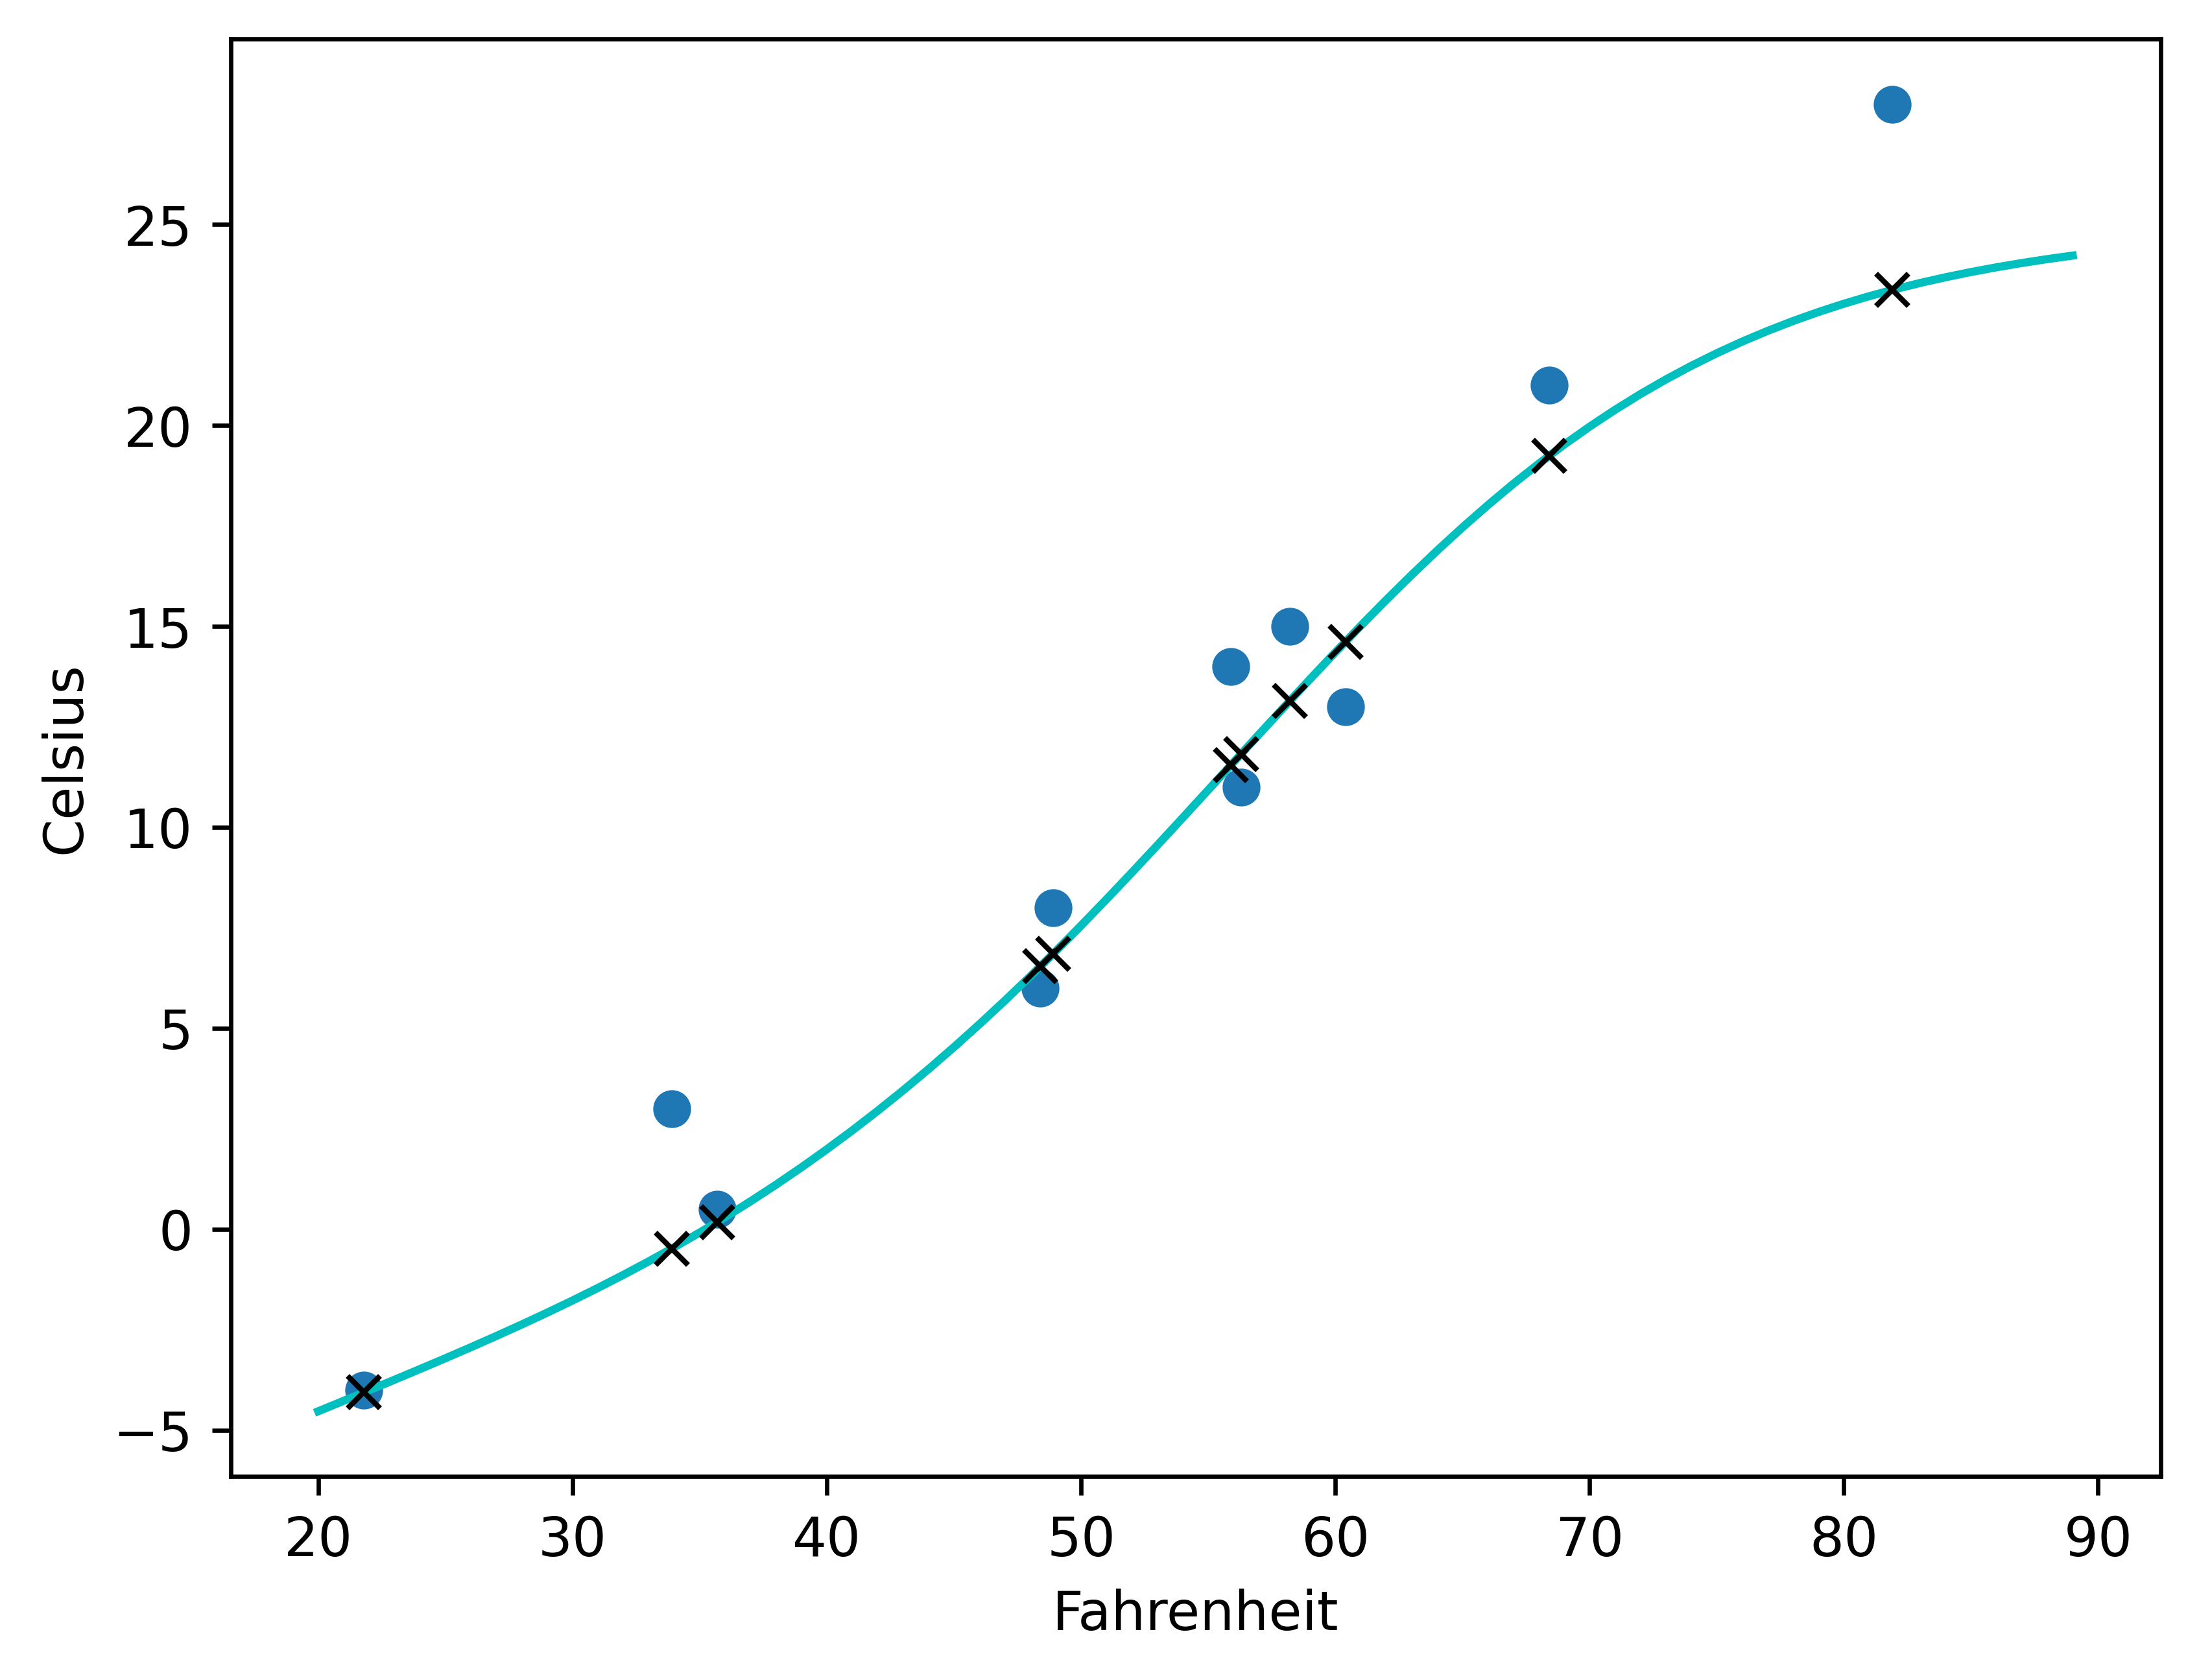

In [60]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1*t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1*t_u).detach().numpy(), 'kx')

1．在简单的神经网络模型中实验隐藏神经元的数量，以及学习率。

a）什么变化会导致模型产生更多的线性输出？

b）你能让模型明显地过拟合数据吗？

c）训练后的损失是高还是低？

In [69]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 16)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(16,1))
    ]))
seq_model, [(name, param.shape) for name, param in seq_model.named_parameters()]

(Sequential(
   (hidden_linear): Linear(in_features=1, out_features=16, bias=True)
   (hidden_activation): Tanh()
   (output_linear): Linear(in_features=16, out_features=1, bias=True)
 ),
 [('hidden_linear.weight', torch.Size([16, 1])),
  ('hidden_linear.bias', torch.Size([16])),
  ('output_linear.weight', torch.Size([1, 16])),
  ('output_linear.bias', torch.Size([1]))])

In [70]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
training_loop(n_epochs=5000, 
              optimizer=optimizer, 
              model=seq_model,
              loss_fn=loss_fn, 
              t_u_train=t_un_train, t_u_val=t_un_val,
              t_c_train=t_c_train, t_c_val=t_c_val)
print("====")
print("output ", seq_model(t_un_val))
print("expected answer ", t_c_val)
print("hidden ", seq_model.hidden_linear.weight.grad)

Epoch: 1, training loss:144.4262, validation loss: 400.2979
Epoch: 1000, training loss:6.8465, validation loss: 74.4105
Epoch: 2000, training loss:2.7413, validation loss: 33.0454
Epoch: 3000, training loss:3.3366, validation loss: 23.4644
Epoch: 4000, training loss:2.1697, validation loss: 15.4321
Epoch: 5000, training loss:1.7745, validation loss: 11.3417
====
output  tensor([[24.8961],
        [-0.0450]], grad_fn=<AddmmBackward0>)
expected answer  tensor([[28.],
        [ 3.]])
hidden  tensor([[-5.1761e+00],
        [-7.9917e-01],
        [ 2.9669e+00],
        [ 3.7688e+00],
        [-5.5363e+00],
        [-1.9924e-03],
        [ 3.0996e+00],
        [-8.0857e-01],
        [ 2.8853e+00],
        [-4.8260e+00],
        [-6.6356e-01],
        [-4.9223e-01],
        [ 2.8874e+00],
        [-7.8334e-01],
        [ 3.0971e+00],
        [-7.6298e-01]])


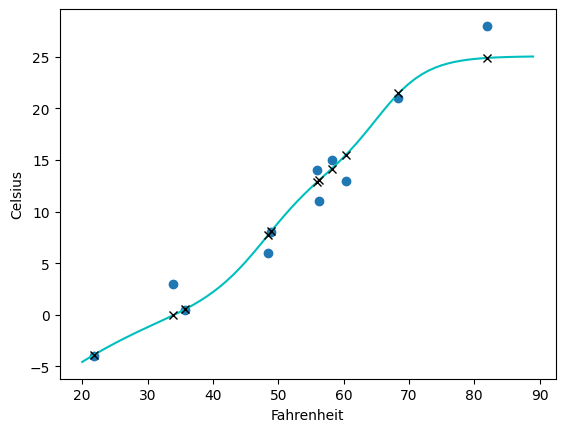

In [71]:
t_range = torch.arange(20., 90.).unsqueeze(1)
# fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1*t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1*t_u).detach().numpy(), 'kx')

In [ ]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 1)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(1,1))
    ]))
seq_model, [(name, param.shape) for name, param in seq_model.named_parameters()]

In [76]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
training_loop(n_epochs=5000, 
              optimizer=optimizer, 
              model=seq_model,
              loss_fn=loss_fn, 
              t_u_train=t_un_train, t_u_val=t_un_val,
              t_c_train=t_c_train, t_c_val=t_c_val)
print("====")
print("output ", seq_model(t_un_val))
print("expected answer ", t_c_val)
print("hidden ", seq_model.hidden_linear.weight.grad)

Epoch: 1, training loss:1.2448, validation loss: 5.2618
Epoch: 1000, training loss:1.2446, validation loss: 5.2527
Epoch: 2000, training loss:1.2444, validation loss: 5.2439
Epoch: 3000, training loss:1.2442, validation loss: 5.2351
Epoch: 4000, training loss:1.2440, validation loss: 5.2263
Epoch: 5000, training loss:1.2438, validation loss: 5.2177
====
output  tensor([[27.1099],
        [-0.1053]], grad_fn=<AddmmBackward0>)
expected answer  tensor([[28.],
        [ 3.]])
hidden  tensor([[-0.0006],
        [-0.0030],
        [ 0.0013],
        [ 0.0030],
        [-0.0006],
        [ 0.0006],
        [ 0.0015],
        [-0.0033],
        [ 0.0011],
        [-0.0006],
        [-0.0040],
        [-0.0033],
        [ 0.0011],
        [-0.0039],
        [ 0.0015],
        [-0.0040]])


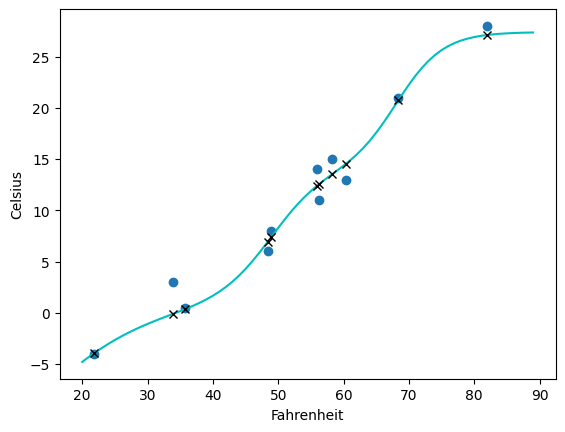

In [77]:
t_range = torch.arange(20., 90.).unsqueeze(1)
# fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1*t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1*t_u).detach().numpy(), 'kx')

2．加载第4章中的葡萄酒数据集，并使用适当数量的输入参数创建一个新模型。

a）与我们使用的温度数据相比，需要多长时间来训练？

b）你能解释一下影响训练时间的因素吗？

c）在对这个数据集进行训练时，你能减小损失吗？

d）你将如何绘制此数据集的图形？

In [79]:
import csv
wine_path = '../data/p1ch4/tabular-wine/winequality-white.csv'
wine_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)
col_list = next(csv.reader(open(wine_path), delimiter=';'))
wine_numpy.shape, col_list, wine_numpy

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'],
 array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
        [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
        [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
        ...,
        [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
        [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
        [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32))

In [80]:
wineq = torch.from_numpy(wine_numpy)
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

In [85]:
wine_data = wineq[:, :-1]
wine_target = wineq[:,-1].long()
wine_data.shape, wine_target.shape, wine_target.dtype

(torch.Size([4898, 11]), torch.Size([4898]), torch.int64)

In [88]:
wine_target_onehot = torch.zeros(wine_target.shape[0], 10)
wine_target_onehot.scatter_(1, wine_target.unsqueeze(1),1.0)
wine_target_onehot.shape, wine_target_onehot

(torch.Size([4898, 10]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [89]:
n_samples = wine_data.shape[0]
n_val = int(0.3 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
wine_data_train = wine_data[train_indices]
wine_target_train = wine_target_onehot[train_indices]

wine_data_val = wine_data[val_indices]
wine_target_val = wine_target_onehot[val_indices]
wine_data_train.shape, wine_target_train.shape, wine_data_val.shape, wine_target_val.shape

(torch.Size([3429, 11]),
 torch.Size([3429, 10]),
 torch.Size([1469, 11]),
 torch.Size([1469, 10]))

In [94]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(11, 24)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(24,10))
    ]))
seq_model, [(name, param.shape) for name, param in seq_model.named_parameters()]

(Sequential(
   (hidden_linear): Linear(in_features=11, out_features=24, bias=True)
   (hidden_activation): Tanh()
   (output_linear): Linear(in_features=24, out_features=10, bias=True)
 ),
 [('hidden_linear.weight', torch.Size([24, 11])),
  ('hidden_linear.bias', torch.Size([24])),
  ('output_linear.weight', torch.Size([10, 24])),
  ('output_linear.bias', torch.Size([10]))])

In [95]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
training_loop(n_epochs=5000, 
              optimizer=optimizer, 
              model=seq_model,
              loss_fn=loss_fn, 
              t_u_train=wine_data_train, t_u_val=wine_data_val,
              t_c_train=wine_target_train, t_c_val=wine_target_val)
print("====")
print("output ", seq_model(wine_data_val[0]))
print("expected answer ", wine_target_val[0])

Epoch: 1, training loss:0.3532, validation loss: 0.3608
Epoch: 1000, training loss:0.0675, validation loss: 0.0685
Epoch: 2000, training loss:0.0674, validation loss: 0.0684
Epoch: 3000, training loss:0.0673, validation loss: 0.0684
Epoch: 4000, training loss:0.0673, validation loss: 0.0683
Epoch: 5000, training loss:0.0672, validation loss: 0.0682
====
output  tensor([-0.0029, -0.0034,  0.0171, -0.0047,  0.0419,  0.3179,  0.4566,  0.1800,
         0.0316,  0.0042], grad_fn=<ViewBackward0>)
expected answer  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
